# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Этапы исследования:
- предобрабтка данных - данные будут очищены от пустых значений и вбросов, приведены к корректному типу;
- кодирование категориальных признаков, а также масштабирование количественных;
- разделение данных на выборки;
- построение моделей: Дерево решений, Случайный лес, а также моделей градиентного бустинга с помощью Catboost и lightgbm;
- оценка метрики качества (RMSE);
- оценка времени, затраченного моделью на обучение и предсказание;
- сравнение моделей и выбор оптимальной;
- проверка выбранной модели на тестовой выборке;
- выводы.

## Подготовка данных

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import time

### Изучение общей информации

In [23]:
df = pd.read_csv('/datasets/autos.csv', index_col=[0], parse_dates=[0])  
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
DateCrawled,,,,,,,,,,,,,,,
2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354369 entries, 2016-03-24 11:52:17 to 2016-03-20 19:41:08
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
 11  DateCreated        354369 non-null  object
 12  NumberOfPictures   354369 non-null  int64 
 13  PostalCode         354369 non-null  int64 
 14  LastSeen           354369 non-null  object
dtypes: int64(7), object(8)
memory usag

In [25]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [26]:
df.duplicated().sum()

89

Типы данных в столбцах соответствуют содержимому. В стоблцах с типом автомобиля, коробкой передач, моделью, типом топлива и сведениями о ремонте имеются пропуски. Помимо характеристик автомобиля, датафрейм содержит данные о пользователе (индекс, дата загрузки объявления). Названия столбцов содержат заглавные буквы, однако поскольку многие названия составные, приведение к нижнему регистру сделает их трудно читаемыми.

### Обработка дубликатов и пропусков

В данных имеются дубликаты, пропуски, а также сведения, очевидно не влияющие на цену. В частности, это личные данные - почтовый индекс владельца, дата последней активности пользователя, дата скачивания анкеты. Удалила эти признаки. Для определения возраста автомобиля достаточно столбца "год регистрации автомобиля", поэтому также удалила столбец "месяц регистрации автомобиля". Кроме того, удалила дубликаты

In [27]:
# Удаляю явные дубликаты
df = df.drop_duplicates()
df.duplicated().sum()

0

Сами по себе столбцы с датами не очень информативны, однако на их основе можно составить столбец со сведениями о том, сколько дней автомобиль был в продаже. Для этого перевела столбцы "Дата создания объявления" и "Дата последней активности" в формат datetime, полученую разницу между этими столбцами поместила в отдельный столбец "дни в продаже".

In [28]:
# Меняю тип данных
df[['DateCreated', 'LastSeen']] = df[['DateCreated', 'LastSeen']].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%S')
# Создаю столбец с разницей 
df['DaysInSale'] = df['LastSeen'] - df['DateCreated']
# Для удобства оставлю в столбце только дни в продаже, и переведу его тип в целочисленный
df['DaysInSale'] = df['DaysInSale'].astype('timedelta64[D]').astype('int')
# Смотрю, корректно ли добавился столбец
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysInSale
DateCrawled,,,,,,,,,,,,,,,,
2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,14
2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,14
2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,22
2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,0
2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,6


In [32]:

# Удаляю персональные данные и колонки с датами
df = df.drop(columns=['DateCreated','RegistrationMonth', 'PostalCode','LastSeen'])

Изучим и обработаем пропуски в данных

In [33]:
# Оцениваю количество пропусков 
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19832
Power                   0
Model               19705
Kilometer               0
FuelType            32892
Brand                   0
Repaired            71149
NumberOfPictures        0
DaysInSale              0
dtype: int64

In [34]:
# Смотрю, какие значения содержатся в столбцах, в которых есть пропуски
columns = ['VehicleType', 'Gearbox','FuelType', 'Repaired']
for i in columns:
    print(df[i].value_counts())
    print('_________________')


sedan          91428
small          79812
wagon          65146
bus            28772
convertible    20199
coupe          16153
suv            11992
other           3288
Name: VehicleType, dtype: int64
_________________
manual    268177
auto       66271
Name: Gearbox, dtype: int64
_________________
petrol      216300
gasoline     98689
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
_________________
no     247081
yes     36050
Name: Repaired, dtype: int64
_________________


Пропуски обработаю следующим образом: 
-  "NotRepaired" пользователи могли игнорировать и не заполнять в случае, если автомобиль не был в ремонте. Заполню пустые значения как 'no';
- столбцы с типом коробки передач и топливом заполню самыми распространенными типами - механическая и бензин соответственно;
-  пропуски с столбцах с типом автомобиля и моделью автомобиля замолню на значение "неизвестен" (пропусков больше 10%, при удалении потеряется большая часть данных, что нежелательно)

In [35]:
df['Repaired'] = df['Repaired'].fillna('no')
df['Gearbox'] = df['Gearbox'].fillna('manual')
df['FuelType']= df['FuelType'].fillna('petrol')
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')

# Проверяю, что обработка пропусков проведена корректно
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
NumberOfPictures    0
DaysInSale          0
dtype: int64

Пропуски обработаны

### Обработка аномальных значений

In [36]:
df.describe(percentiles=[.01, .03, .05, .25, .5, .75, .99])

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures,DaysInSale
count,354280.000000,354280.000000,354280.000000,354280.000000,354280.0,354280.000000
mean,4416.458541,2004.234859,110.090256,128211.090098,0.0,8.677916
std,4514.138905,90.239242,189.872001,37906.417793,0.0,8.639700
min,0.000000,1000.000000,0.000000,5000.000000,0.0,0.000000
1%,0.000000,1980.000000,0.000000,5000.000000,0.0,0.000000
3%,0.000000,1990.000000,0.000000,20000.000000,0.0,0.000000
5%,200.000000,1992.000000,0.000000,40000.000000,0.0,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0,2.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0,13.000000


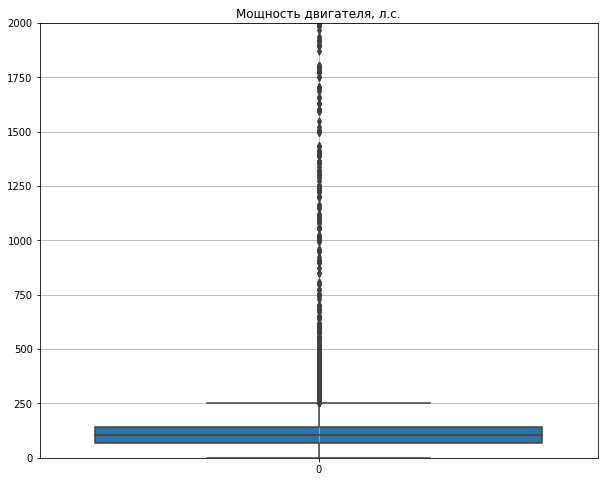

In [37]:
# Построю диаграмму размаха для мощности двигателя
plt.figure(figsize=(10, 8))
sns.boxplot(data=df['Power'])
plt.title('Мощность двигателя, л.с.')
plt.grid(True)
plt.ylim(0, 2000)
plt.show()

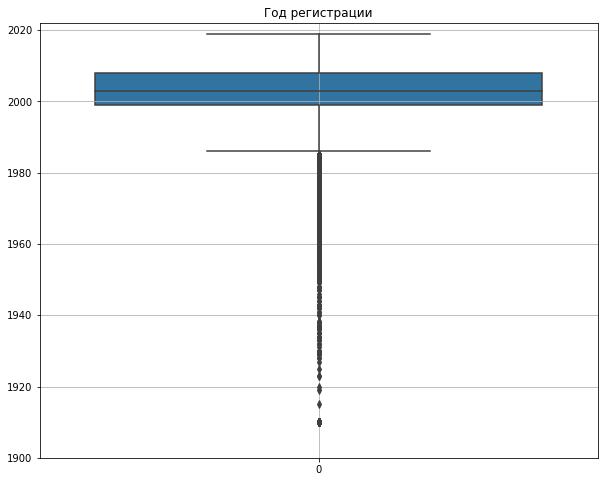

In [38]:
# Построю диаграмму размаха для года регистрации
plt.figure(figsize=(10, 8))
sns.boxplot(data=df['RegistrationYear'])
plt.title('Год регистрации')
plt.grid(True)
plt.ylim(1900, 2022)
plt.show()

В данных имеются вбросы - нулевые значения мощности и цены, также есть аномально высокие значение мощности в тысячи лошадиных сил, не достижимые для автомобильных двигателей. Кроме того, имеются автомобили начала прошлого века, что может как быть вбросом, так и раритетным авто. 

- Судя по объявлениям в Интернете, за автомобиль, проданный на металлолом, можно выручить от 15000 рублей (около 187 евро) то есть продавать автомобиль (средним весом от 1 до 1,5 тонн) дешевле хотя бы 200 евро даже на запчасти не выглядит логичным. Владельцам проще и выгоднее было бы продать такие авто как металлолом. Поэтому отбрасываю значения цены ниже 200 евро;
- Кроме того, вряд ли старинные редкие раритетные автомобили продаются на общих площадках, а не на специализированных. Скорее всего, это вбросы. Чтобы удалить вбросы и оставить только просто старые автомобили, возьму объявления с годом автомобиля не ниже 1980. Тем более модели в дальшейнем придется работать с обычными авто, которых продается несоизмеримо больше;
- Также удалю значения мощности выше 600 л.с. (с учетом самых мощных спорткаров). Кроме того, удалю совсем низкие значени мощности ниже 9 (мощность самой маленькой малолитражки в мире по данным сайта cars.ru);
- Кроме того, есть зависшие объявления, которые в продаже несколько лет. Удалю эти объявления как вбросы. 99 процентов объявлений попадают в месячный интервал, отброшу остальное. 

In [16]:
df = df[(df['Price']>=200)\
       &(df['RegistrationYear']>=1970)&(df['RegistrationYear']<2017)\
       &(df['Power'] <=1600)&(df['Power']>=9)\
       &(df['DaysInSale']<=31)].reset_index()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354280 entries, 2016-03-24 11:52:17 to 2016-03-20 19:41:08
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354280 non-null  int64 
 1   VehicleType       354280 non-null  object
 2   RegistrationYear  354280 non-null  int64 
 3   Gearbox           354280 non-null  object
 4   Power             354280 non-null  int64 
 5   Model             354280 non-null  object
 6   Kilometer         354280 non-null  int64 
 7   FuelType          354280 non-null  object
 8   Brand             354280 non-null  object
 9   Repaired          354280 non-null  object
 10  NumberOfPictures  354280 non-null  int64 
 11  DaysInSale        354280 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


### Подготовка признаков для обучени моделей

In [40]:
# выделяю признаки, на которых будет обучаться модель, и целевой признак

features = df.drop(['Price'], axis=1) 
target = df['Price'] # целевой признак 

# Разделю данные на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split\
(features, target, test_size=0.25, random_state=12345)

feature_names = features_train.columns.values.tolist ()
# вывожу размеры полученных выборок
print('Размер обучающей выборки', len(features_train))
print('Размер тестовой выборки', len(features_test))

Размер обучающей выборки 265710
Размер тестовой выборки 88570


Среди признаков имеются категориальные, а количественные признаки имеют разный масштаб. Отмасштабирую численные признаки с помощью StandartScaler. Для кодирования категориальных буду использовать OrdinalEncoder(). 

In [41]:
# Выделяю категориальные признаки
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
# Выделяю признаки, которые необходимо масштабировать
numeric= ['RegistrationYear','Power','Kilometer','NumberOfPictures']

# Создаю преобразователь 
col_transformer = ColumnTransformer(transformers=[
                                   ('oe', OrdinalEncoder(), category), ('ss', StandardScaler(), numeric)])

# Обучаю преобразователь на тренировочной выборке
col_transformer.fit(features_train)

# Преобразовываю обучающую выборку
features_train = pd.DataFrame(col_transformer.transform(features_train), index=features_train.index)
# Преобразовываю тестовую выборку
features_test = pd.DataFrame(col_transformer.transform(features_test), index=features_test.index)


In [42]:
features_train.head()
                                       

,0,1,2,3,4,5,6,7,8,9
DateCrawled,,,,,,,,,,
2016-03-30 18:44:43,8.0,1.0,166.0,2.0,38.0,0.0,0.017822,-0.005582,0.575855,0.0
2016-03-19 14:36:22,8.0,1.0,166.0,6.0,22.0,0.0,-0.100317,0.062595,0.575855,0.0
2016-03-25 00:40:37,5.0,0.0,42.0,6.0,24.0,0.0,-0.068097,-0.577218,0.575855,0.0
2016-03-12 12:55:25,4.0,1.0,2.0,2.0,0.0,0.0,-0.014398,0.156993,0.575855,0.0
2016-03-17 19:37:17,8.0,0.0,15.0,2.0,2.0,0.0,-0.046618,0.387745,0.575855,0.0


In [43]:
features_test.head()

,0,1,2,3,4,5,6,7,8,9
DateCrawled,,,,,,,,,,
2016-03-25 17:57:44,8.0,1.0,166.0,4.0,5.0,0.0,-0.057357,-0.000338,0.575855,0.0
2016-03-10 12:40:33,0.0,1.0,238.0,2.0,20.0,0.0,-0.014398,-0.042293,0.575855,0.0
2016-03-30 09:50:14,8.0,1.0,170.0,2.0,38.0,0.0,-0.025138,0.209437,0.575855,0.0
2016-03-18 23:53:31,8.0,1.0,11.0,6.0,2.0,0.0,0.017822,0.209437,0.575855,0.0
2016-03-17 21:50:47,5.0,1.0,75.0,6.0,27.0,0.0,0.050041,-0.183891,-1.535148,0.0


В рамках предобработки данных:
- заполнены пропуски в данных. Там, где это возможно, пропуски заполнены самым распространенным значением, в других случаях пропуски заполнены значением "неизвестно" (во избежание потери большого числа данных);
- удалены аномальные значения цены, года выпуска и мощности;
- удалены столбцы с личными даннными, не влияющими на целевую переменную (почтовый индекс, дата создания, дата загрузки, дата последней активности, месяц регистрации автомобиля);
- в результате датафрейм сократился на 15%;
- выделены целевой и обучающие признаки;
- данные разделены на обучающую и тестовую выборки;
- категориальные признаки закодированы с помощью OneHotEncoder();
- количественные признаки отмасштабированы.

## Обучение моделей

Построю и обучу несколько моделей - дерево решений, случайный лес, модели градиентного бустинга с помощью LightGBM и CatBoost. 

### Дерево решений

In [22]:

# Инициирую модель Дерево решений
model_dt=DecisionTreeRegressor(random_state=12345)
parameters= {'max_depth':range(1,10)}                                    
grid_dt=GridSearchCV(model_dt,param_grid=parameters,
                     scoring='neg_mean_squared_error',
                     cv=5) 

# Обучаю модель
# start = time.time()
model_dt_final = grid_dt.fit(features_train, target_train)
#end = time.time()
#learn_time_dt = round(end-start, 4)

# Делаю предсказания
start = time.time()
model_dt_final.predict(features_train)
end = time.time()
predict_time_dt=round(end-start,2)
print('Время предсказания модели Дерево решений (секунды):', predict_time_dt)

# Считаю RMSE 
dt_rmse = ((model_dt_final.best_score_)*(-1))**0.5
print('Лучшее значение глубины для Дерева решений:', model_dt_final.best_params_)
print('RMSE модели Дерево решений:', dt_rmse)


Время предсказания модели Дерево решений (секунды): 0.02
Лучшее значение глубины для Дерева решений: {'max_depth': 9}
RMSE модели Дерево решений: 2019.1283815106515


In [24]:
# Отдельно замеряю, сколько будет обучаться модель на лучших параметрах
model_dt_final = DecisionTreeRegressor(random_state=12345, max_depth=9)
model_dt_final.fit(features_train, target_train)
end = time.time()
learn_time_dt = round(end-start, 4)
print('Время обучения модели Дерево решений с лучшими гиперпараметрами (секунды):', learn_time_dt)

Время обучения модели Дерево решений с лучшими гиперпараметрами (секунды): 0.3636


### Случайный лес

In [25]:
# Инициирую модель 
model_rf = RandomForestRegressor(random_state=12345)
parameters= {'max_depth':(10,50),
             'n_estimators':range(10, 50, 10)}                                 
grid_rf=GridSearchCV(model_rf,param_grid=parameters,
                     scoring='neg_mean_squared_error',
                     cv=5) 

# Обучаю модель
model_rf_final = grid_rf.fit(features_train, target_train)

# Делаю предсказания
start = time.time()
model_rf_final.predict(features_train)
end = time.time()
predict_time_rf=round(end-start,2)
print('Время предсказания модели  Случайный лес (секунды):', predict_time_rf)

# Считаю RMSE 
rf_rmse = ((model_rf_final.best_score_)*(-1))**0.5
print('Лучшее значение параметров для Случайного леса:', model_rf_final.best_params_)
print('RMSE модели Случайный лес:', rf_rmse)


Время предсказания модели  Случайный лес (секунды): 3.09
Лучшее значение параметров для Случайного леса: {'max_depth': 50, 'n_estimators': 40}
RMSE модели Случайный лес: 1588.0870833079882


In [26]:
# Отдельно замеряю, сколько будет обучаться модель на лучших параметрах
start = time.time()
model_rf_final = RandomForestRegressor(random_state=12345, max_depth=50, n_estimators=40)
model_rf_final.fit(features_train, target_train)
end = time.time()
learn_time_rf = round(end-start, 5)
print('Время обучения модели Случайный лес с лучшими гиперпараметрами (секунды):', learn_time_rf)

Время обучения модели Случайный лес с лучшими гиперпараметрами (секунды): 19.61682


###  LightGBM

In [27]:
model_lgb = lgb.LGBMRegressor()
parameters = {'max_depth':[5, 10, 15]}
             #'learning_rate':[0.01, 0.1]}

grid_lgbm = GridSearchCV(model_lgb,param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=3)                        
                          
# Обучаю модель

model_lgb_final = grid_lgbm.fit(features_train, target_train)

# Делаю предсказания
start = time.time()
model_lgb_final.predict(features_train)
end = time.time()
predict_time_lgbm = round(end-start,2)
print('Время предсказания модели   LightGBM (секунды):', predict_time_lgbm)

# Считаю RMSE 
lgbm_rmse = ((model_lgb_final.best_score_)*(-1))**0.5
print('Лучшее значение параметров для  LightGBM:', model_lgb_final.best_params_)
print('RMSE модели LightGBM:', lgbm_rmse)

Время предсказания модели   LightGBM (секунды): 1.62
Лучшее значение параметров для  LightGBM: {'max_depth': 15}
RMSE модели LightGBM: 1669.5420651743616


In [28]:
# Отдельно замеряю, сколько будет обучаться модель на лучших параметрах
start = time.time()
model_lgb_final = lgb.LGBMRegressor(max_depth=15)
model_lgb_final.fit(features_train, target_train)
end = time.time()
learn_time_lgbm = round(end-start, 4)
print('Время обучения модели LightGBM с лучшими гиперпараметрами (секунды):', learn_time_lgbm)

Время обучения модели LightGBM с лучшими гиперпараметрами (секунды): 4.0723


### CatBoost

In [29]:
model_cat= CatBoostRegressor(loss_function='RMSE', iterations=30, random_state=12345)
parameters = {'max_depth':[5, 10, 15, 20,25],
            # 'learning_rate':[0.01, 0.1, 0.15]}


grid_cat= GridSearchCV(model_cat,param_grid=parameters,
                     scoring='neg_mean_squared_error',
                    cv=5) 
# Обучаю модель
model_cat_final = grid_cat.fit(features_train, target_train)

# Делаю предсказания
start = time.time()
model_cat_final.predict(features_train)
end = time.time()
predict_time_cat = round(end-start,2)
print('Время предсказания модели   CatBoost (секунды):', predict_time_cat)

# Считаю RMSE 
cat_rmse = ((model_cat_final.best_score_)*(-1))**0.5
print('Лучшее значение параметров для  CatBoost:', model_cat_final.best_params_)
print('RMSE модели CatBoost:', cat_rmse)


0:	learn: 4571.9894199	total: 73.8ms	remaining: 2.14s
1:	learn: 4542.9105455	total: 95.5ms	remaining: 1.34s
2:	learn: 4513.4198581	total: 119ms	remaining: 1.07s
3:	learn: 4485.4391797	total: 139ms	remaining: 904ms
4:	learn: 4457.3410893	total: 159ms	remaining: 796ms
5:	learn: 4429.9577251	total: 179ms	remaining: 717ms
6:	learn: 4402.9910957	total: 199ms	remaining: 654ms
7:	learn: 4375.8479489	total: 220ms	remaining: 604ms
8:	learn: 4349.4157208	total: 241ms	remaining: 563ms
9:	learn: 4323.2506048	total: 266ms	remaining: 531ms
10:	learn: 4297.7688038	total: 286ms	remaining: 494ms
11:	learn: 4271.5665476	total: 307ms	remaining: 460ms
12:	learn: 4246.5119533	total: 327ms	remaining: 427ms
13:	learn: 4221.0625904	total: 346ms	remaining: 396ms
14:	learn: 4196.4079651	total: 366ms	remaining: 366ms
15:	learn: 4170.9182038	total: 385ms	remaining: 337ms
16:	learn: 4146.0702791	total: 407ms	remaining: 311ms
17:	learn: 4122.3180453	total: 427ms	remaining: 285ms
18:	learn: 4098.9257683	total: 447ms

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 4310.7638700	total: 22.5ms	remaining: 653ms
1:	learn: 4055.3394702	total: 50.4ms	remaining: 706ms
2:	learn: 3836.4673127	total: 73.4ms	remaining: 660ms
3:	learn: 3628.1816160	total: 93.6ms	remaining: 608ms
4:	learn: 3451.1182104	total: 123ms	remaining: 614ms
5:	learn: 3295.2899040	total: 146ms	remaining: 582ms
6:	learn: 3152.9831785	total: 168ms	remaining: 551ms
7:	learn: 3030.8882679	total: 189ms	remaining: 520ms
8:	learn: 2922.1034312	total: 211ms	remaining: 493ms
9:	learn: 2827.8894812	total: 234ms	remaining: 468ms
10:	learn: 2746.8371404	total: 255ms	remaining: 441ms
11:	learn: 2675.2731537	total: 276ms	remaining: 414ms
12:	learn: 2610.5689459	total: 297ms	remaining: 389ms
13:	learn: 2551.0229445	total: 317ms	remaining: 363ms
14:	learn: 2503.0519304	total: 337ms	remaining: 337ms
15:	learn: 2460.0953684	total: 358ms	remaining: 313ms
16:	learn: 2422.0111743	total: 377ms	remaining: 288ms
17:	learn: 2380.7312027	total: 397ms	remaining: 264ms
18:	learn: 2349.9397167	total: 415

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 4170.0134421	total: 21.1ms	remaining: 613ms
1:	learn: 3812.2966832	total: 42.7ms	remaining: 598ms
2:	learn: 3515.0982056	total: 76.7ms	remaining: 690ms
3:	learn: 3269.8941783	total: 96.1ms	remaining: 625ms
4:	learn: 3075.0168599	total: 117ms	remaining: 584ms
5:	learn: 2906.5670257	total: 137ms	remaining: 546ms
6:	learn: 2763.2924174	total: 156ms	remaining: 514ms
7:	learn: 2651.6034055	total: 176ms	remaining: 483ms
8:	learn: 2562.4915402	total: 195ms	remaining: 456ms
9:	learn: 2490.9415508	total: 214ms	remaining: 428ms
10:	learn: 2423.0306911	total: 234ms	remaining: 404ms
11:	learn: 2365.6271279	total: 255ms	remaining: 382ms
12:	learn: 2320.7861950	total: 273ms	remaining: 357ms
13:	learn: 2278.1872431	total: 293ms	remaining: 335ms
14:	learn: 2245.7680547	total: 311ms	remaining: 311ms
15:	learn: 2212.6698844	total: 332ms	remaining: 290ms
16:	learn: 2186.0704942	total: 350ms	remaining: 268ms
17:	learn: 2164.8149356	total: 371ms	remaining: 247ms
18:	learn: 2139.5937989	total: 391

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 4075.5048813	total: 574ms	remaining: 16.7s
1:	learn: 3642.1784255	total: 1.15s	remaining: 16.1s
2:	learn: 3291.5122866	total: 1.73s	remaining: 15.6s
3:	learn: 2996.9832963	total: 2.33s	remaining: 15.1s
4:	learn: 2754.3871228	total: 2.9s	remaining: 14.5s
5:	learn: 2547.1962103	total: 3.53s	remaining: 14.1s
6:	learn: 2383.9379360	total: 4.1s	remaining: 13.5s
7:	learn: 2252.0414998	total: 4.69s	remaining: 12.9s
8:	learn: 2142.2758920	total: 5.28s	remaining: 12.3s
9:	learn: 2053.7200015	total: 5.86s	remaining: 11.7s
10:	learn: 1980.5417937	total: 6.43s	remaining: 11.1s
11:	learn: 1921.9216554	total: 7.01s	remaining: 10.5s
12:	learn: 1872.9216541	total: 7.58s	remaining: 9.92s
13:	learn: 1835.6995170	total: 8.16s	remaining: 9.33s
14:	learn: 1802.9474714	total: 8.75s	remaining: 8.75s
15:	learn: 1775.5230753	total: 9.32s	remaining: 8.15s
16:	learn: 1747.0197939	total: 9.89s	remaining: 7.56s
17:	learn: 1728.7184517	total: 10.5s	remaining: 6.98s
18:	learn: 1709.8580443	total: 11.1s	rem

In [32]:
# Отдельно замеряю, сколько будет обучаться модель на лучших параметрах
start = time.time()
model_cat_final = CatBoostRegressor(loss_function='RMSE', iterations=30, random_state=12345,\
                                    learning_rate=0.15, max_depth=15)
model_cat_final.fit(features_train, target_train)
end = time.time()
learn_time_cat = round(end-start, 5)
print('Время обучения модели CatBoost с лучшими гиперпараметрами (секунды):', learn_time_cat)

0:	learn: 4075.5048813	total: 616ms	remaining: 17.9s
1:	learn: 3642.1784255	total: 1.19s	remaining: 16.7s
2:	learn: 3291.5122866	total: 1.76s	remaining: 15.9s
3:	learn: 2996.9832963	total: 2.33s	remaining: 15.2s
4:	learn: 2754.3871228	total: 2.92s	remaining: 14.6s
5:	learn: 2547.1962103	total: 3.52s	remaining: 14.1s
6:	learn: 2383.9379360	total: 4.18s	remaining: 13.8s
7:	learn: 2252.0414998	total: 4.79s	remaining: 13.2s
8:	learn: 2142.2758920	total: 5.4s	remaining: 12.6s
9:	learn: 2053.7200015	total: 6s	remaining: 12s
10:	learn: 1980.5417937	total: 6.58s	remaining: 11.4s
11:	learn: 1921.9216554	total: 7.15s	remaining: 10.7s
12:	learn: 1872.9216541	total: 7.73s	remaining: 10.1s
13:	learn: 1835.6995170	total: 8.31s	remaining: 9.5s
14:	learn: 1802.9474714	total: 8.91s	remaining: 8.91s
15:	learn: 1775.5230753	total: 9.48s	remaining: 8.3s
16:	learn: 1747.0197939	total: 10.1s	remaining: 7.68s
17:	learn: 1728.7184517	total: 10.6s	remaining: 7.08s
18:	learn: 1709.8580443	total: 11.2s	remaining

Выводы: обучены четыре модели, наилучшее значение точности показала модель Случайный лес

## Анализ моделей

### Сравнение моделей

In [33]:
# Собираю показатели моделей и время их обучения и предсказаний
final_df = pd.DataFrame({'RMSE':[dt_rmse, rf_rmse, lgbm_rmse, cat_rmse],\
                         'Время обучения':[learn_time_dt, learn_time_rf, learn_time_lgbm, learn_time_cat],\
                         'Время предсказания':[predict_time_dt, predict_time_rf,\
                                               predict_time_lgbm, predict_time_cat]},\
                         index=['Дерево решений','Случайный лес','LightGBM', 'CatBoost'])
final_df

,RMSE,Время обучения,Время предсказания
Дерево решений,2019.128382,0.36360,0.02
Случайный лес,1588.087083,19.61682,3.09
LightGBM,1669.542065,4.07230,1.62
CatBoost,1674.364700,18.47168,0.06


В результате обучения четырех моделей:
- наивысшую скорость работы показала модель Дерево решений, однако низкая точность не позволет назвать ее оптимальной;
- точность модели LightGBM выше, однако и скорость обучения у нее максимальная;
- наилучшие показатели у модели Случайный лес и CatBoost, при этом модель Случайный лес достигает бОльшей точности.

По итогам сравнения предлагаю остановится на модели Случайный лес, как на самой точной.

### Проверка лушей модели на тестовой выборке

Проверяю выбранную модель на тестовой выборке

In [34]:
model_rf = RandomForestRegressor(random_state=12345, max_depth=50, n_estimators=40)
model_rf.fit(features_train, target_train)
predictions_test = model_rf.predict(features_test)

rf_rmse = mean_squared_error(target_test, predictions_test) ** .5
print('RMSE модели Случайный лес:', rf_rmse)

RMSE модели Случайный лес: 1557.9754957658472


Качество предсказаний на тестовой выборке не ниже, чем на тренировочной

Выводы:
- В ходе исследования заполнены пропуски в данных. Там, где это возможно, пропуски заполнены самым распространенным значением, в других случаях пропуски заполнены значением "неизвестно" (во избежание потери большого числа данных);
- в данные добавлен столбец с числом дней в продаже;
- в данных присутствовали аномальные значения цены, года выпуска и мощности, а также аномальные значения длительности размещения объвления. Аномалии удалены;
- удалены столбцы с личными даннными, не влияющими на целевую переменную (почтовый индекс, дата создания, дата загрузки, дата последней активности, месяц регистрации автомобиля);
- в результате датафрейм сократился на 15%;
- выделены целевой и обучающие признаки;
- данные разделены на обучающую и тестовую выборки;
- категориальные признаки закодированы с помощью OneHotEncoder();
- количественные признаки отмасштабированы;
- построены модели Дерево решений, случаынй лес, LightGBM и Catboost.
- по результатам в качестве отптимальной отобрана модель Случайный лес;
- выбранная модель проверена на тестовой выборке.
